In [83]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite.filters
import matplotlib.patches as mpatches
import scipy

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman as RomanInstrument

In [84]:
save_dir = os.path.join(config.machine.data_dir, 'output', 'lowest_detectable_subhalo_mass')
results = util.unpickle_all(save_dir, 'results_', '.pkl')

In [85]:
pprint(results[0].keys())

dict_keys(['4_2048_2048'])


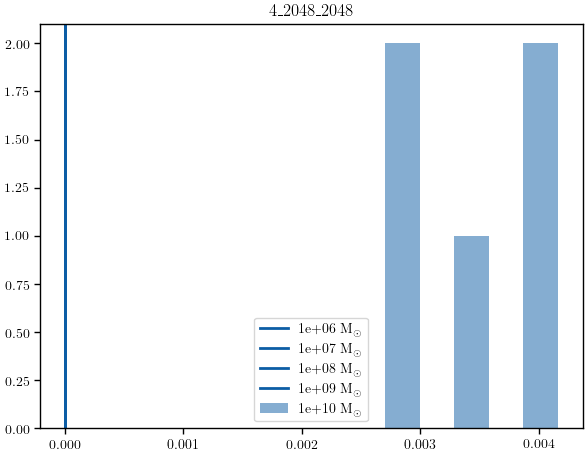

In [93]:
sample_position_key = '4_2048_2048'
sample_results = results[1][sample_position_key]

mass_list, median_list, maxes, mins = [], [], [], []
for mass, chi_squared_list in sample_results.items():
    mass_list.append(mass)
    median_list.append(np.median(chi_squared_list))
    maxes.append(np.max(chi_squared_list))
    mins.append(np.min(chi_squared_list))
    if all(v == 0 for v in chi_squared_list):
        plt.axvline(0, label=f'{float(mass):.0e} M$_\odot$')
    else:
        plt.hist(chi_squared_list, label=f'{float(mass):.0e} M$_\odot$', alpha=0.5, bins=5)

uplims = np.array(maxes) - np.array(median_list)
lolims = np.array(median_list) - np.array(mins)

# plt.xscale('log')
plt.title(sample_position_key)
plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_01_histogram.png'))
plt.show()

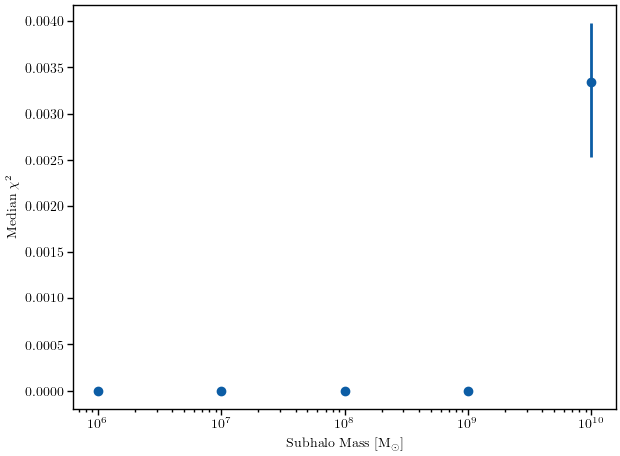

In [94]:
mass_list = [float(mass) for mass in mass_list]
plt.errorbar(mass_list, median_list, yerr=[uplims, lolims], fmt='o')
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('Median $\chi^2$')
plt.xscale('log')
plt.savefig(os.path.join(figure_dir, 'ldsm_02_errorbar.png'))
plt.show()

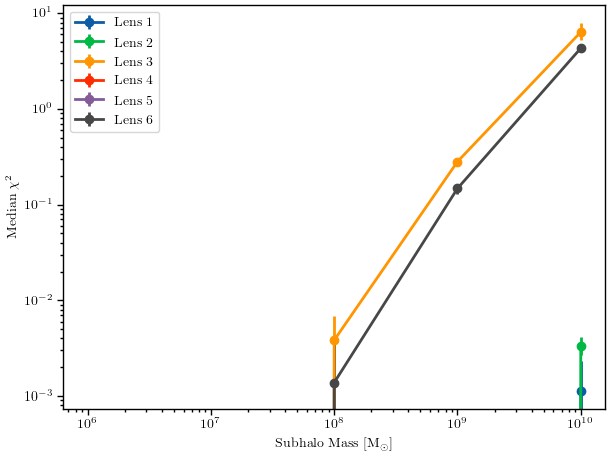

In [95]:
sample_position_key = '4_2048_2048'  # 16_2048_2048

for i, result in enumerate(results[:7]):
    sample_results = result[sample_position_key]

    mass_list, median_list, maxes, mins = [], [], [], []
    for mass, chi_squared_list in sample_results.items():
        mass_list.append(mass)
        median_list.append(np.median(chi_squared_list))
        maxes.append(np.max(chi_squared_list))
        mins.append(np.min(chi_squared_list))
        uplims = np.array(maxes) - np.array(median_list)
        lolims = np.array(median_list) - np.array(mins)

    mass_list = [float(mass) for mass in mass_list]
    plt.errorbar(mass_list, median_list, yerr=[lolims, uplims], fmt='o', label=f'Lens {i + 1}', ls='-')
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('Median $\chi^2$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_03_lenses.png'))
plt.show()

In [96]:
from scipy.stats import chi2

pixels = 42 ** 2
df = pixels - 3  # 3 dof: subhalo x, subhalo y, subhalo mass

rv = chi2(df)

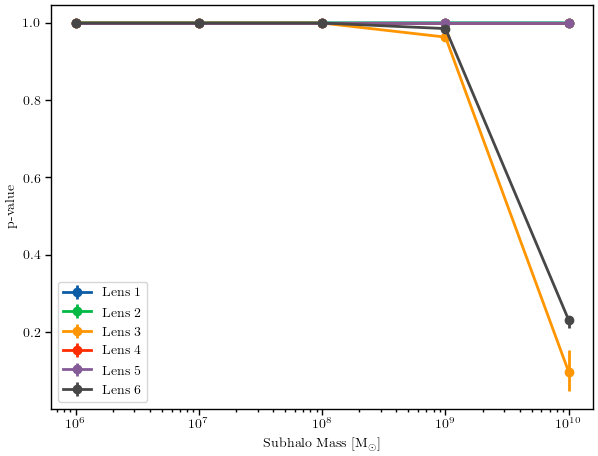

In [97]:
sample_position_key = '4_2048_2048'  # 16_2048_2048

for i, result in enumerate(results[:10]):
    sample_results = result[sample_position_key]

    mass_list, median_list, maxes, mins = [], [], [], []
    for mass, chi_squared_list in sample_results.items():
        p_list = [chi2.sf(chi, 3) for chi in chi_squared_list]
        mass_list.append(mass)
        median_list.append(np.median(p_list))
        maxes.append(np.max(p_list))
        mins.append(np.min(p_list))
        uplims = np.array(maxes) - np.array(median_list)
        lolims = np.array(median_list) - np.array(mins)

    mass_list = [float(mass) for mass in mass_list]
    plt.errorbar(mass_list, median_list, yerr=[lolims, uplims], fmt='o', label=f'Lens {i + 1}', ls='-')
plt.xlabel('Subhalo Mass [M$_\odot$]')
plt.ylabel('p-value')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.savefig(os.path.join(figure_dir, 'ldsm_04_p_vals.png'))
plt.show()

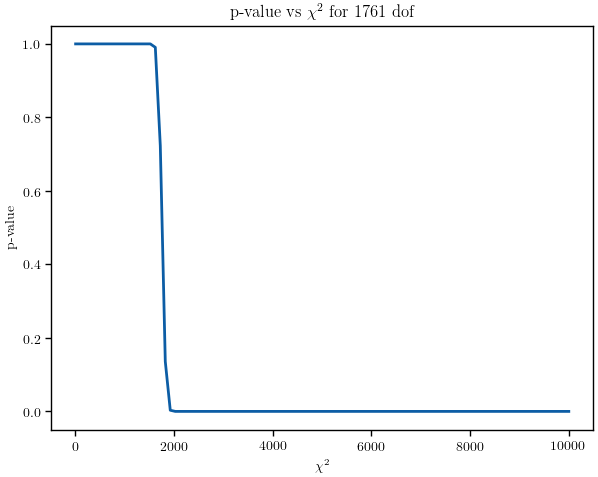

In [98]:
p_vals = np.linspace(1e1, 1e4, 100)
plt.plot(p_vals, [chi2.sf(p, df) for p in p_vals])
plt.xlabel('$\chi^2$')
plt.ylabel('p-value')
plt.title('p-value vs $\chi^2$ for {} dof'.format(df))
plt.show()

In [99]:
import scipy.stats as scipy_stats

def calculate_sigma(p_value, X, mu, tail_type='one-tailed'):
    if tail_type == 'two-tailed':
        # Divide the p-value by 2 for a two-tailed test
        p_value /= 2

    # Get the z-score from the p-value
    z_score = scipy_stats.norm.ppf(1 - p_value)

    # Calculate sigma
    sigma = (X - mu) / z_score

    return sigma

# Example usage
p_value = 0.025  # Example p-value
X = 60           # Observed value
mu = 50          # Mean of the distribution

sigma = calculate_sigma(p_value, X, mu, tail_type='one-tailed')
print(f"Calculated Sigma: {sigma}")

Calculated Sigma: 5.102134569246539
